📚 Import Libraries

In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3"

'70 10 20.txt'	 test   train   val


In [ ]:
EPOCHS = 50
data_dir = "../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

Data Preparatin

In [ ]:
# Path ke folder dataset (ganti sesuai lokasi)
data_dir = "../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3"

# Subfolder: train, val, test
data_folders = {
    'train': os.path.join(data_dir, 'train'),
    'val': os.path.join(data_dir, 'val'),
    'test': os.path.join(data_dir, 'test'),
}

# Transformasi data per fase
def data_transforms(phase):
    if phase == 'train':
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomRotation(5),                                #
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1),
                                     scale=(0.9, 1.1)),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

# Buat dataset per fase
image_datasets = {
    phase: datasets.ImageFolder(data_folders[phase], transform=data_transforms(phase))
    for phase in ['train', 'val', 'test']
}

# Buat DataLoader per fase
dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=64, shuffle=(phase == 'train'))
    for phase in ['train', 'val', 'test']
}

# Info jumlah data per fase
dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val', 'test']}

# Daftar nama kelas (misal: ['Normal', 'TBC_Aktif', 'TBC_Laten'])
class_names = image_datasets['train'].classes

# Cek info dasar
print("Jumlah data per fase:", dataset_sizes)
print("Kelas yang terdeteksi:", class_names)


Jumlah data per fase: {'train': 3150, 'val': 450, 'test': 900}
Kelas yang terdeteksi: ['aktif', 'laten', 'normal']


In [ ]:
# Normal = 0, AKtif = 1, Laten = 2

label_order = {'Normal': 0, 'Aktif': 1, 'Laten': 2}

for phase in ['train', 'val', 'test']:
    dataset = image_datasets[phase]
    dataset.class_to_idx = label_order
    label_map_reverse = {v: k for k, v in dataset.class_to_idx.items()}
    dataset.targets = [
        label_order[label_map_reverse[class_idx]]
        for class_idx in dataset.targets
    ]

# Update class_names agar konsisten
class_names = ['Normal', 'Aktif', 'Laten']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Cek
print(f"Classes: {class_names}")
print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"Test size: {dataset_sizes['test']}")


Classes: ['Normal', 'Aktif', 'Laten']
Train size: 3150
Validation size: 450
Test size: 900


Define

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Simpan history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            preds_epoch = []
            labels_epoch = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == VAL:
                    preds_epoch.extend(preds.cpu().numpy())
                    labels_epoch.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == VAL:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    all_preds = preds_epoch
                    all_labels = labels_epoch

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history, all_preds, all_labels


In [ ]:
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load("../content/drive/MyDrive/Colab Notebooks/Dataset/pretrained-models/vgg16-397923af.pth"))

<All keys matched successfully>

In [ ]:
# Unfreeze beberapa layer terakhir (fine-tuning)
for param in model_pre.features[24:].parameters():
    param.requires_grad = True


In [ ]:
# Ganti classifier untuk disesuaikan dengan jumlah kelas
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Linear(num_features, len(class_names))


In [ ]:
model_pre = model_pre.to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer hanya untuk layer yang trainable (yang requires_grad = True)
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model_pre.parameters()),
    lr=0.001, momentum=0.9, weight_decay=1e-4
)
print(model_pre)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Hyperparameter

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Train

In [ ]:
TRAIN = 'train'
VAL = 'val'

# Panggil fungsi train_model
trained_model, history, all_preds, all_labels = train_model(
    model=model_pre,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    num_epochs=EPOCHS
)

print("Training selesai!")

Epoch 1/50
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.6984 Acc: 0.6854
val Loss: 0.5777 Acc: 0.7644
Epoch 2/50
----------
train Loss: 0.4430 Acc: 0.8292
val Loss: 0.4828 Acc: 0.8111
Epoch 3/50
----------
train Loss: 0.3312 Acc: 0.8825
val Loss: 0.4763 Acc: 0.8089
Epoch 4/50
----------
train Loss: 0.2447 Acc: 0.9108
val Loss: 0.5608 Acc: 0.7533
Epoch 5/50
----------
train Loss: 0.2347 Acc: 0.9162
val Loss: 0.4878 Acc: 0.8133
Epoch 6/50
----------
train Loss: 0.1839 Acc: 0.9289
val Loss: 0.5611 Acc: 0.7778
Epoch 7/50
----------
train Loss: 0.1741 Acc: 0.9387
val Loss: 0.5061 Acc: 0.8044
Epoch 8/50
----------
train Loss: 0.1159 Acc: 0.9575
val Loss: 0.6058 Acc: 0.7844
Epoch 9/50
----------
train Loss: 0.1156 Acc: 0.9562
val Loss: 0.4298 Acc: 0.8311
Epoch 10/50
----------
train Loss: 0.0998 Acc: 0.9625
val Loss: 0.5342 Acc: 0.8111
Epoch 11/50
----------
train Loss: 0.0703 Acc: 0.9771
val Loss: 0.5452 Acc: 0.8156
Epoch 12/50
----------
train Loss: 0.0687 Acc: 0.9740
val Loss: 0.5586 Acc: 0.8178
Epoch 13/50
----------
train Loss: 

In [ ]:
torch.save(model_pre.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Dataset/15-june-vgg16_tb_70-10-20.pth')

Evaluasi

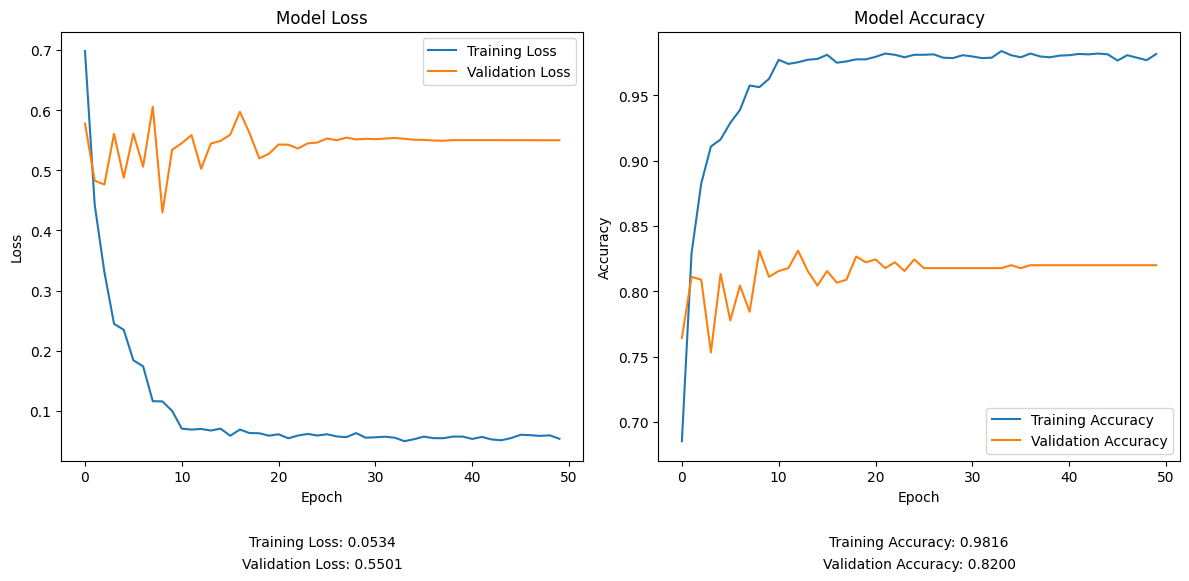

In [ ]:
import matplotlib.pyplot as plt

# Membuat subplots dengan 1 baris dan 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualisasi Loss
# Access the keys directly from the history dictionary
axes[0].plot(history['train_loss'], label='Training Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Menampilkan nilai terakhir loss di bawah grafik
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
axes[0].text(0.5, -0.2, f'Training Loss: {final_train_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)
axes[0].text(0.5, -0.25, f'Validation Loss: {final_val_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)

# Visualisasi Accuracy
# Access the keys directly from the history dictionary
axes[1].plot(history['train_acc'], label='Training Accuracy')
axes[1].plot(history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Menampilkan nilai terakhir accuracy di bawah grafik
final_train_accuracy = history['train_acc'][-1]
final_val_accuracy = history['val_acc'][-1]
axes[1].text(0.5, -0.2, f'Training Accuracy: {final_train_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)
axes[1].text(0.5, -0.25, f'Validation Accuracy: {final_val_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)

# Menambahkan legend ke kedua grafik
axes[0].legend()
axes[1].legend()

# Menampilkan plot
plt.tight_layout()  # Untuk mengatur jarak antar grafik
plt.show()

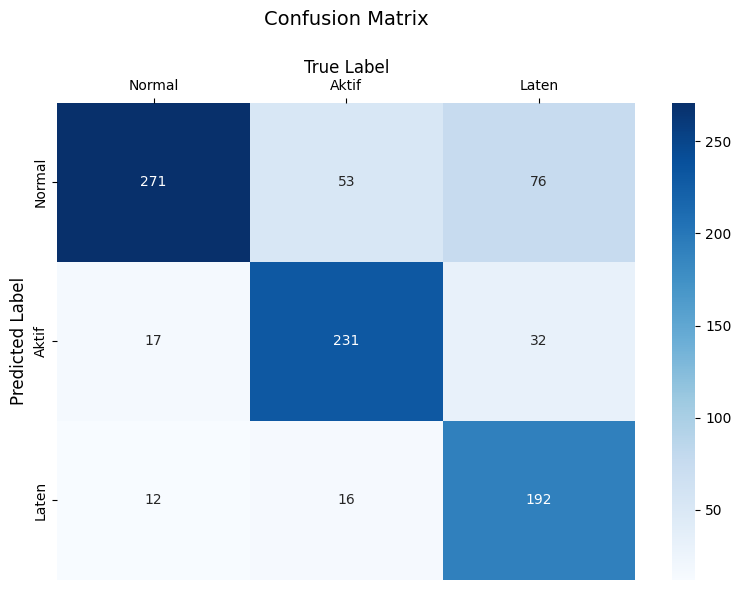

Accuracy : 0.7711
Precision: 0.7917
Recall   : 0.7711
F1 Score : 0.7698

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.90      0.77       300
       Aktif       0.82      0.77      0.80       300
       Laten       0.87      0.64      0.74       300

    accuracy                           0.77       900
   macro avg       0.79      0.77      0.77       900
weighted avg       0.79      0.77      0.77       900



In [ ]:
# 1. Import Library
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# 2. Fungsi evaluasi model
def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    return np.array(all_labels), np.array(all_preds), avg_loss

# 3. Jalankan evaluasi untuk mendapatkan label
test_true_labels, test_pred_classes, test_loss = evaluate_model(
    trained_model, dataloaders['test'], device, criterion
)

# 4. Gunakan variabel sebagai y_true dan y_pred
y_true = test_true_labels
y_pred = test_pred_classes
class_names = ['Normal', 'Aktif', 'Laten']

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 6. Tampilkan dengan baris = prediksi (transpose cm)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title("Confusion Matrix\n", pad=40, fontsize=14)
plt.tight_layout()
plt.show()

# 7. Metrik Evaluasi
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
test_true_labels, test_pred_classes, test_loss = evaluate_model(trained_model, dataloaders['test'], device, criterion)

from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(test_true_labels, test_pred_classes)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.7711
Test Loss: 0.7543


# LOAD DAN TESTING

In [ ]:
%matplotlib inline

import copy
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Buat ulang model dengan struktur yang sama saat pelatihan
trained_model = models.vgg16(pretrained=False)
trained_model.classifier[6] = torch.nn.Linear(4096, 3)  # jumlah kelas = 3

# 2. Load
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Dataset/15-june-vgg16_tb_70-10-20.pth'))

# 3. Kirim ke device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)
trained_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torchvision.datasets import ImageFolder

class ImageFolderWithPaths(ImageFolder):
    """Subclass dari ImageFolder agar juga mengembalikan file path."""

    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]  # ambil path dari gambar
        return original_tuple + (path,)  # (image, label, path)


In [ ]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return original_tuple + (path,)


In [ ]:
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
test_dataset = ImageFolderWithPaths(
    '../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test',
    transform=transform
)

dataloaders = {}
dataloaders['test'] = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def test_vgg_model(model, dataloader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_inputs = []
    all_confs = []
    all_filenames = []

    running_corrects = 0
    running_total = 0

    with torch.no_grad():
        for inputs, labels, paths in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_inputs.extend(inputs.cpu())
            all_confs.extend(confs.cpu().numpy())
            all_filenames.extend(paths)

            running_corrects += torch.sum(preds == labels.data)
            running_total += inputs.size(0)

    acc = running_corrects.double() / running_total
    print(f"Test Accuracy: {acc:.4f}")

    return (np.array(all_labels), np.array(all_preds),
            all_inputs, np.array(all_confs), all_filenames)

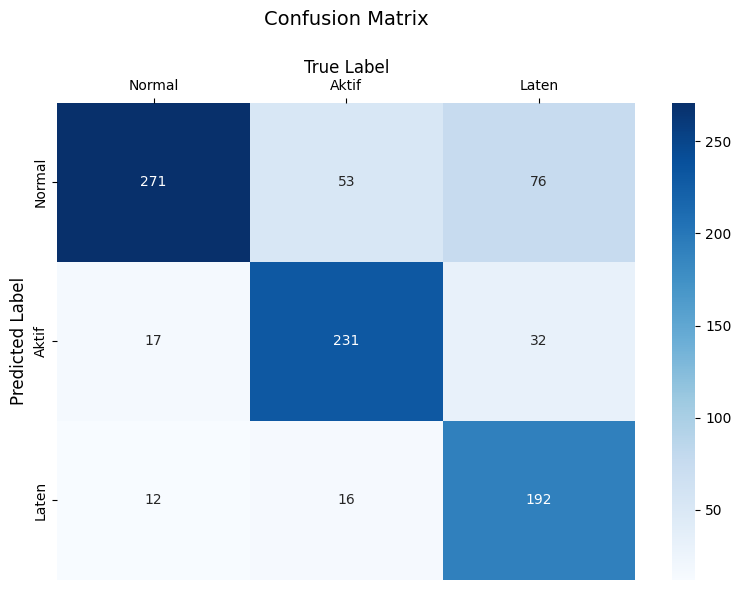

Accuracy : 0.7711
Precision: 0.7917
Recall   : 0.7711
F1 Score : 0.7698

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.90      0.77       300
       Aktif       0.82      0.77      0.80       300
       Laten       0.87      0.64      0.74       300

    accuracy                           0.77       900
   macro avg       0.79      0.77      0.77       900
weighted avg       0.79      0.77      0.77       900



In [ ]:
# 1. Import Library
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# 2. Tentukan loss function
criterion = nn.CrossEntropyLoss()

# 3. Fungsi evaluasi model (fix untuk 3 item dari dataloader)
def evaluate_model(model, dataloader, device, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # ← path diabaikan
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    return np.array(all_labels), np.array(all_preds), avg_loss

# 4. Jalankan evaluasi
test_true_labels, test_pred_classes, test_loss = evaluate_model(
    trained_model, dataloaders['test'], device, criterion
)

# 5. Inisialisasi variabel evaluasi
y_true = test_true_labels
y_pred = test_pred_classes
class_names = ['Normal', 'Aktif', 'Laten']

# 6. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 7. Tampilkan dengan baris = prediksi (transpose cm)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title("Confusion Matrix\n", pad=40, fontsize=14)
plt.tight_layout()
plt.show()

# 8. Tampilkan metrik evaluasi
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
acc = accuracy_score(test_true_labels, test_pred_classes)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7711


In [ ]:
def show_predictions_grid(images, true_labels, pred_labels, class_names, confidences, filenames, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        if i >= len(images):
            break

        img = unnormalize(images[i])
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(6, 6, i + 1)
        plt.imshow(img_np)

        true_class = class_names[true_labels[i]]
        pred_class = class_names[pred_labels[i]]
        conf_percent = confidences[i] * 100

        # Cek apakah prediksi benar
        is_correct = true_labels[i] == pred_labels[i]
        color = 'green' if is_correct else 'red'

        # Ambil nama file saja tanpa path
        filename = filenames[i].split('/')[-1]

        # Judul dengan nama file + label + confidence
        plt.title(f"{filename}\nTrue: {true_class}\nPred: {pred_class} ({conf_percent:.1f}%)", fontsize=8, color=color)
        plt.axis('off')

    #plt.subplots_adjust(wspace=1.5, hspace=0.5)  # wspace = jarak horizontal, hspace = vertikal
    plt.tight_layout()
    plt.show()


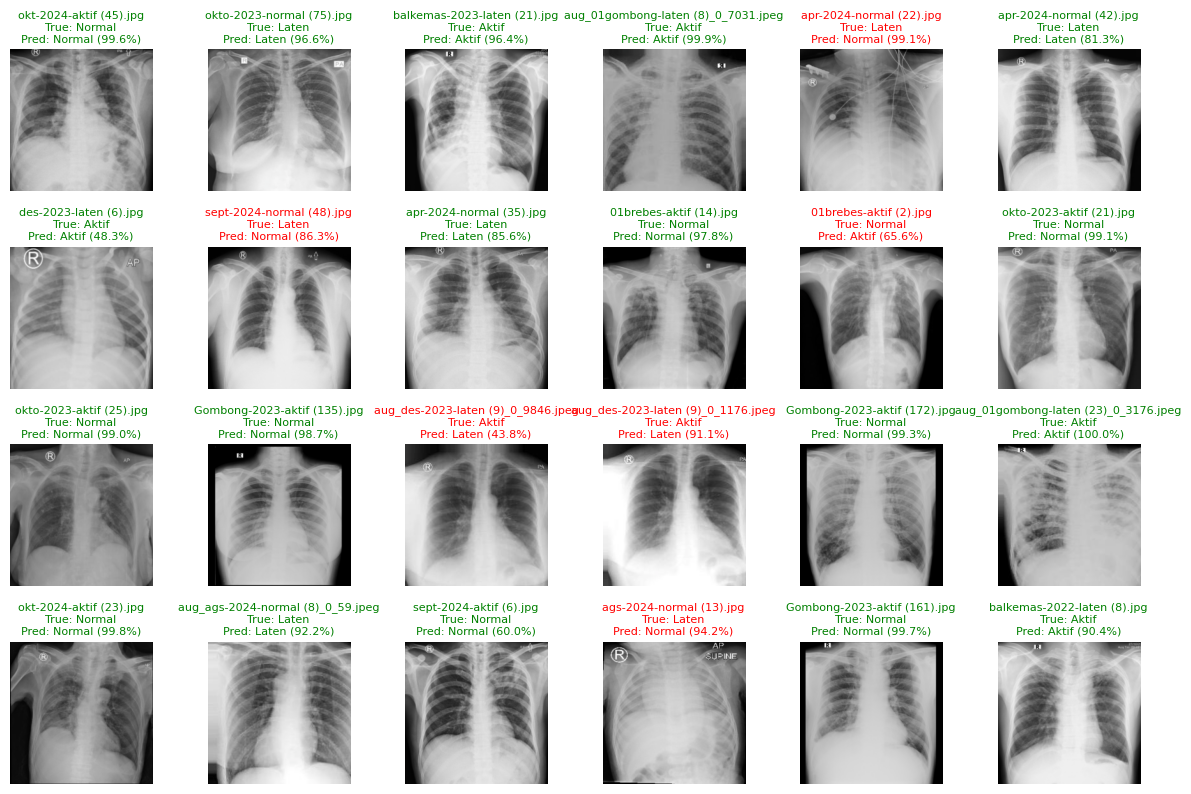

In [ ]:
combined = list(zip(input_images, true_labels, pred_labels, confidences, filenames))
random.shuffle(combined)
input_images, true_labels, pred_labels, confidences, filenames = zip(*combined)

input_images = list(input_images)
true_labels = list(true_labels)
pred_labels = list(pred_labels)
confidences = list(confidences)
filenames = list(filenames)

show_predictions_grid(
    input_images,
    true_labels,
    pred_labels,
    ['Normal', 'Aktif', 'Laten'],
    confidences,
    filenames,
    num_images=24
)


SAVE XLSX

In [ ]:
import os
import pandas as pd

save_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/'
csv_path = os.path.join(save_dir, 'hasil-prediksi-VGG-70-10-20.csv')
xlsx_path = os.path.join(save_dir, 'hasil-prediksi-VGG-70-10-20.xlsx')

# Nama kelas
class_names = ['Normal', 'TBC Aktif', 'TBC Laten']
true_labels_str = [class_names[label] for label in true_labels]
pred_labels_str = [class_names[label] for label in pred_labels]

# Buat DataFrame, filename hanya nama file (tanpa path)
df = pd.DataFrame({
    'Filename': [os.path.basename(f) for f in filenames],
    'True Label': true_labels_str,
    'Predicted Label': pred_labels_str,
    'Confidence': confidences
})

#buat urutin data
df = df.sort_values(by=['True Label', 'Filename'])

# Simpan ke CSV
df.to_csv(csv_path, index=False)
print(f"Hasil prediksi CSV disimpan di: {csv_path}")

# Simpan ke Excel (XLSX)
df.to_excel(xlsx_path, index=False)
print(f"Hasil prediksi Excel disimpan di: {xlsx_path}")


Hasil prediksi CSV disimpan di: /content/drive/MyDrive/Colab Notebooks/Dataset/hasil-prediksi-VGG-70-10-20.csv
Hasil prediksi Excel disimpan di: /content/drive/MyDrive/Colab Notebooks/Dataset/hasil-prediksi-VGG-70-10-20.xlsx
